In [18]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.svm import SVR
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
df = pd.read_csv('epi_r.csv')

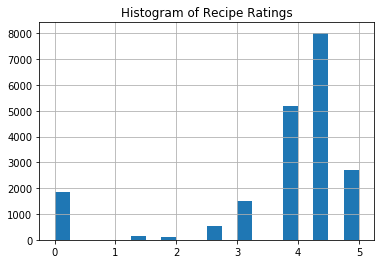

In [4]:
df.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [5]:
null_count = df.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [11]:
df = df.drop(['title'], 1)

In [12]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df)
df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)

In [14]:
svr = SVR()
X = df.drop(['rating', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = df.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

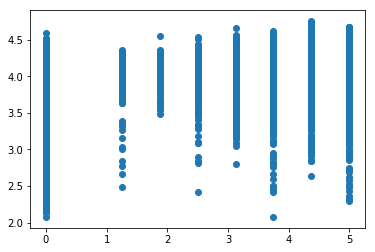

In [15]:
plt.scatter(Y, svr.predict(X))

In [16]:
svr.score(X, Y)

0.03856570651298896

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=10)

array([0.03567144, 0.00461333, 0.0177773 , 0.04075881, 0.01658424,
       0.0507569 , 0.01839022, 0.0331821 , 0.01184219, 0.04390324])

In [19]:
svr = SVR()
X = df.drop(['rating'], 1)
Y = df.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [20]:
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(df))

In [21]:
print(X_pca.head(5))

             0             1          2          3         4         5   \
0 -8.184640e+03 -1.418167e+02 -15.526447 -21.637007  1.415227 -0.674594   
1 -7.602809e+03  5.152540e+02 -55.828227  36.976020 -0.498554 -1.090878   
2 -8.643703e+03 -2.548172e+02 -36.085181 -20.119863  0.199401 -0.990798   
3 -2.563142e-09 -3.069754e-07   0.000007   0.000012 -1.558638  0.832345   
4 -8.167771e+03 -3.044066e+02 -24.386629 -17.578503  0.604255 -0.339092   

         6         7         8         9     ...           20        21  \
0 -0.038646 -0.021405  0.043995  0.007890    ...     0.210253 -0.155135   
1  0.437412 -0.582323  0.497610 -0.366309    ...     0.354227  0.125606   
2 -0.095951  0.728757  0.212144 -0.157845    ...    -0.261423 -0.318970   
3 -0.734161 -0.868972  0.180821  0.253935    ...    -0.292908  0.092252   
4  0.329515 -0.407337 -0.335160 -1.344379    ...    -0.531360 -0.452350   

         22        23        24        25        26        27        28  \
0 -0.555170  0.090171  

In [23]:
svr.score(X, Y)

0.15783756458095788

In [24]:
svr.fit(X_pca,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
svr.score(X_pca, Y)

0.764203542703978

As a linear support vector, the PCA seems to have locted the 30 best features and is predicting at a very high level versus our original score. However, the assignment is to create a binary classifier SVM. I'll split off the rating column into 5-star and non 5-star. 

In [27]:
df['fiveStar'] = np.where(df['rating']==5, 1, 0)

In [29]:
df5 = df.drop(['rating'], 1)
svr = SVR()
X = df.drop(['fiveStar'], 1)
Y = df.fiveStar
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Now we'll run the SVR for the original features. Then I'll run PCA to pick the 30 best and re-run it so we can compare the results from the regression to that of the binary classifier. 

In [30]:
svr.score(X, Y)

0.3945081207763034

Considering our first pass resulted in an SVR score of 0.039, this is a full order of magnitude better. Still, I'm not sure this would exceed random now that we're dealing with a binary classifier. Regardless of how poor the first pass was and the improvement this is, it's still pretty poor and I wouldn't want to present this to Epicurious as a model for predicting 5-star ratingns. Time for PCA. 

In [31]:
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(df5))

In [32]:
svr.fit(X_pca,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [33]:
svr.score(X_pca, Y)

0.9117057605369305

Now that's what I'm talking about! By using PCA to determine the 30 best features we've created a model that scores .9117! This means that the proportion of variance that is predictable from the independent variables is 91.17%. That's much higher than our previous models without being alarming high such to suggest overfitting. 

Time to call the Epicurious folks to give them the good news. 